# Emerging Topics final code - AI

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("pandemic_corpus.pkl")
#df.reset_index(inplace=True)

# ai corpus
df = pd.read_pickle("../../data/prd/JSM21/ai_corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,206,206,1094356,1130812,PROJECT SUMMARY / ABSTRACTModern digital patho...,2019,1,1,Modern digital pathology departments produce a...,M,3058,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme...",actionable mutation; anticancer research; Arc...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,5F31CA214029-03,1/11/2017,1/10/2020,"SCHAUMBERG, ANDREW JAMES",NaN,12,060217502,WEILL MEDICAL COLLEGE OF CONRELL UNIVERSITY,NEW YORK,NY,100654805,UNITED STATES,1/11/2019,1/10/2020,93.398,2019,45016.0,NaN
1,207,207,938623,931185,PROJECT SUMMARY / ABSTRACTModern digital patho...,2017,1,1,Modern digital pathology departments produce a...,M,3059,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme...",actionable mutation; anticancer research; Arc...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,1F31CA214029-01,1/11/2017,1/10/2020,"SCHAUMBERG, ANDREW JAMES",NaN,12,060217502,WEILL MEDICAL COLLEGE OF CONRELL UNIVERSITY,NEW YORK,NY,100654805,UNITED STATES,1/11/2017,1/10/2018,93.398,2017,44044.0,NaN
2,2940,2940,197954,119775,This is funding to support participation by ap...,2009,1,1,This is funding to support participation by ap...,T,3170,e,"[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, participation, approximately, graduate,...",Academia; Artificial Intelligence; Arts; base...,SUPPORTING STUDENTS ATTENDING IUI 2009 CONFERENCE,NSF,NSF,NaN,0914591,2/1/2009,1/31/2010,"WELD, DANIEL S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,98195-9472,UNITED STATES,NaN,NaN,47.070,2009,3459.0,NaN
3,2988,2988,197569,119389,Within the literature on causal statistical in...,2009,1,1,Within the literature on causal statistical in...,W,4672,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, c...",Affect; Agriculture; Applied Research; Area; ...,COLLAB. PROPOSAL: PARTIAL AND POINT IDENTIFICA...,NSF,NSF,NaN,0852139,2/15/2009,1/31/2010,"FLORES-LAGUNES, ALFONSO",NaN,06,019361885,UNIVERSITY OF FLORIDA,GAINESVILLE,FL,32611-2002,UNITED STATES,NaN,NaN,47.075,2009,63287.0,NaN
4,3035,3035,197568,119388,Within the literature on causal statistical in...,2009,1,1,Within the literature on causal statistical in...,W,4714,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, 

In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 2.3859689235687256


/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [9]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('machine_learning', 3.1740800784574197)
('machine', 1.3734485046737686)
('learn', 1.2575954890397638)
('statistical', 0.7326558920406727)
('prediction', 0.6836755941164392)
('framework', 0.5342171579229592)
('feature', 0.5119036776884531)
('domain', 0.45434412035364724)
('scale', 0.44770698823228083)
('representation', 0.437348590766555)

Topic 1:
('robot', 1.9103756719290217)
('environment', 0.24030283847716655)
('people', 0.165153563904546)
('soft', 0.15102555733383582)
('robotics', 0.1488875903935133)
('team', 0.1454574837651496)
('human', 0.1392767484597641)
('interaction', 0.1303473711262801)
('motion', 0.1264697193908637)
('planning', 0.12169923435912305)

Topic 2:
('conference', 1.1753155963111073)
('doctoral', 0.757659276340873)
('student', 0.6719995190832864)
('consortium', 0.6098627552430619)
('participant', 0.4080542767281002)
('international', 0.38192664215786315)
('travel', 0.24367776092377505)
('participation', 0.2402707702077492)
('hold', 0.23153120416195663)


### Emerging Topics

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
sum(df['PROJECT_START_DATE'].isna())

0

In [12]:
df['START_YEAR'].value_counts(dropna=False)

2018    345
2017    216
2016    160
2015    119
2012    109
2014     95
2009     95
2010     91
2013     84
2011     82
2019     77
2008     65
2006      8
2007      6
1977      3
2004      3
2005      3
2000      2
2002      2
1987      2
2003      1
1997      1
Name: START_YEAR, dtype: int64

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.006763,0.0,0.000000,0.034974,0.016869,0.000000,0.023187,0.005342,0.000000,0.000000,0.009647,0.003646,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110330,0.042290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006201,0.000000,2017
1,0.005721,0.0,0.000000,0.034820,0.017186,0.000000,0.023391,0.005571,0.000000,0.000000,0.009717,0.003783,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110772,0.041858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004626,0.000000,2017
2,0.000000,0.0,0.209255,0.000000,0.000000,0.003346,0.000000,0.000000,0.002259,0.004294,0.000000,0.000000,0.0,0.000000,0.014186,0.000956,0.000000,0.106689,0.000000,0.000000,0.000000,0.010801,0.000000,0.000000,0.000000,0.005713,0.007036,0.015387,0.000000,0.000000,2009
3,0.018753,0.0,0.007836,0.002064,0.000000,0.000000,0.002576,0.002552,0.000000,0.000000,0.007081,0.001905,0.0,0.008825,0.012494,0.000000,0.000223,0.000000,0.010138,0.000000,0.018951,0.013825,0.006132,0.012651,0.032074,0.000000,0.000000,0.010973,0.000000,0.006451,2009
4,0.018427,0.0,0.007686,0.002481,0.000000,0.000000,0.002547,0.002737,0.000000,0.000000,0.006769,0.001764,0.0,0.008491,0.012088,0.000000,0.000000,0.000000,0.009357,0.000000,0.019303,0.013224,0.005766,0.014967,0.032255,0.000000,0.000000,0.012607,0.000000,0.006060,2009


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,True,False,False,True,True,False,True,True,False,False,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,2017
1,True,False,False,True,True,False,True,True,False,False,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,2017
2,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,True,True,True,False,False,2009
3,True,False,True,True,False,False,True,True,False,False,True,True,False,True,True,False,True,False,True,False,True,True,True,True,True,False,False,True,False,True,2009
4,True,False,True,True,False,False,True,True,False,False,True,True,False,True,True,False,False,False,True,False,True,True,True,True,True,False,False,True,False,True,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,False,True,False,False,True,False,True,False,False,False,True,True,True,True,False,False,True,True,True,False,True,False,True,False,False,True,False,True,False,False,2018
1565,True,False,False,True,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,True,True,True,True,True,False,False,True,True,True,False,2018
1566,True,False,True,True,True,True,True,True,False,True,False,False,True,True,False,True,True,False,True,True,False,False,True,False,True,False,True,True,False,True,2018
1567,True,True,True,False,False,True,False,True,False,True,False,False,True,True,True,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,2018


In [18]:
topic_count_bool.sum(axis=1).median()

12.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [20]:
#topic_counts

In [21]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2019]  # NO NSF DATA from 2019, was 2020

In [22]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
12,2010,50,29,33,28,33,43,40,27,31,49,20,29,37,42,38,36,25,32,39,26,38,32,43,49,34,35,34,41,31,35
13,2011,37,35,31,25,44,40,40,32,44,38,18,27,37,29,41,33,31,38,37,23,34,34,38,50,30,39,31,46,31,23
14,2012,55,58,39,40,58,62,57,37,41,48,41,35,49,37,48,41,38,45,46,25,48,36,49,64,31,43,42,56,43,32
15,2013,42,38,33,35,42,49,38,26,32,39,24,32,42,25,33,32,23,34,44,18,32,28,50,42,36,24,26,41,35,22
16,2014,45,43,22,33,56,57,52,26,39,35,25,49,39,33,36,37,28,36,40,25,38,34,58,41,39,40,32,42,35,36
17,2015,67,49,38,45,60,57,66,42,46,50,32,41,42,51,50,44,40,54,53,30,40,47,69,60,47,60,34,53,49,40
18,2016,86,70,53,55,95,84,84,62,52,75,42,65,74,51,72,54,43,70,73,40,68,76,93,81,57,56,39,72,54,53
19,2017,115,84,80,75,119,122,106,103,77,81,67,86,119,69,88,84,83,80,87,53,74,71,111,109,91,80,96,92,85,77
20,2018,198,144,107,142,185,187,156,184,104,136,102,118,203,120,122,159,127,158,157,100,144,164,187,176,115,117,106,181,115,136


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     695
Topic 1     550
Topic 2     436
Topic 3     478
Topic 4     692
Topic 5     701
Topic 6     639
Topic 7     539
Topic 8     466
Topic 9     551
Topic 10    371
Topic 11    482
Topic 12    642
Topic 13    457
Topic 14    528
Topic 15    520
Topic 16    438
Topic 17    547
Topic 18    576
Topic 19    340
Topic 20    516
Topic 21    522
Topic 22    698
Topic 23    672
Topic 24    480
Topic 25    494
Topic 26    440
Topic 27    624
Topic 28    478
Topic 29    454
dtype: int64

In [24]:
n_by_topic[0]

695

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2019]  # 2020

In [26]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [27]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1977,0.0,0.000000,0.001952,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.002427,0.000000,0.000000,0.000000,0.0,0.000000,0.000358,0.0,0.000000,0.000000,0.000000,0.012833,0.0,0.000966,0.092131,0.00000,0.000000,0.273570,0.033880,0.0,0.000000
1,1987,0.0,0.000000,0.005450,0.013206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.003656,0.000000,0.000000,0.000000,0.0,0.000000,0.071719,0.00024,0.000000,0.069150,0.007180,0.0,0.006596
2,1997,0.0,0.000000,0.002082,0.000000,0.001415,0.033869,0.000000,0.000000,0.035192,0.000000,0.000000,0.000000,0.006638,0.0,0.000000,0.003483,0.0,0.000000,0.000000,0.077382,0.002502,0.0,0.000000,0.014270,0.00000,0.000000,0.063092,0.028412,0.0,0.003151
3,2000,0.0,0.000000,0.000000,0.000928,0.081452,0.000409,0.051732,0.001695,0.065966,0.000003,0.002810,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.001795,0.000661,0.0,0.011693,0.000000,0.00000,0.000000,0.007255,0.000000,0.0,0.000109
4,2002,0.0,0.000558,0.000000,0.009134,0.034850,0.009184,0.008980,0.005416,0.009151,0.000522,0.007152,0.004642,0.000000,0.0,0.007797,0.000000,0.0,0.000000,0.014074,0.008915,0.043232,0.0,0.005307,0.000000,0.00000,0.017891,0.032701,0.000000,0.0,0.000000


In [28]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2019]  #2020 

In [29]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
12,2010,0.005732,0.020962,0.011869,0.002827,0.009709,0.013880,0.003523,0.006114,0.005063,0.035048,0.012840,0.008693,0.006267,0.016481,0.010916,0.004933,0.011544,0.007331,0.009747,0.005119,0.009444,0.012784,0.018552,0.018835,0.009261,0.011260,0.006861,0.013937,0.007037,0.019608
13,2011,0.006439,0.015689,0.013446,0.004032,0.013757,0.012741,0.006617,0.003903,0.021146,0.003323,0.000887,0.005113,0.006341,0.011088,0.012673,0.008620,0.005681,0.013649,0.012529,0.005487,0.017192,0.016616,0.017411,0.023210,0.011872,0.007723,0.009809,0.020239,0.007632,0.020476
14,2012,0.008587,0.031412,0.013872,0.006837,0.018149,0.009653,0.010216,0.003745,0.012262,0.003713,0.002687,0.009491,0.008048,0.007377,0.008079,0.006210,0.006189,0.011951,0.010775,0.003268,0.008901,0.014124,0.012881,0.024498,0.011166,0.011832,0.010934,0.016739,0.006184,0.005204
15,2013,0.008644,0.021402,0.019503,0.008438,0.014191,0.012258,0.011705,0.009044,0.010230,0.003345,0.001088,0.003486,0.012119,0.005689,0.008409,0.011543,0.007761,0.013604,0.013034,0.002906,0.009379,0.007295,0.021723,0.018288,0.012742,0.014238,0.008601,0.014865,0.009660,0.004317
16,2014,0.006101,0.035309,0.006181,0.005453,0.017246,0.019071,0.009761,0.003949,0.011970,0.002255,0.001191,0.016460,0.008906,0.008839,0.012627,0.006039,0.010767,0.013296,0.011756,0.009070,0.011247,0.009043,0.021980,0.019288,0.015932,0.009906,0.010049,0.009316,0.006207,0.005773
17,2015,0.005689,0.029052,0.012495,0.006673,0.012576,0.012086,0.010573,0.005143,0.012257,0.002322,0.001591,0.007732,0.009617,0.008174,0.011659,0.011281,0.013068,0.017427,0.013228,0.006289,0.006913,0.006317,0.022459,0.015861,0.012753,0.014373,0.012127,0.011655,0.012359,0.010790
18,2016,0.006228,0.025179,0.013322,0.004403,0.016739,0.011320,0.010533,0.008729,0.010468,0.003024,0.001011,0.007227,0.010710,0.009311,0.014863,0.009091,0.008977,0.014868,0.010305,0.001402,0.011532,0.010210,0.024692,0.021380,0.012339,0.015400,0.012616,0.008076,0.011242,0.005920
19,2017,0.007020,0.025650,0.011510,0.004626,0.010429,0.011447,0.007174,0.018870,0.011447,0.003049,0.001269,0.008041,0.018236,0.004199,0.013054,0.017453,0.009426,0.009949,0.012199,0.005446,0.010371,0.007673,0.018794,0.014694,0.010536,0.008276,0.014964,0.009096,0.012458,0.006282
20,2018,0.008528,0.020869,0.007832,0.006900,0.012179,0.012198,0.006759,0.012493,0.007263,0.002744,0.001585,0.006060,0.017620,0.004054,0.010224,0.014793,0.008251,0.012426,0.010602,0.006226,0.015008,0.013017,0.018500,0.017316,0.009884,0.007395,0.013419,0.014367,0.005528,0.006958


In [30]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
12,2010,0.000910,0.006288,0.004898,0.001163,0.002499,0.002987,0.000841,0.003292,0.001257,0.010261,0.008248,0.003065,0.001426,0.005331,0.002505,0.001349,0.003518,0.002185,0.002310,0.002030,0.001778,0.004991,0.003917,0.004258,0.003009,0.005242,0.001831,0.005031,0.001965,0.010097
13,2011,0.001333,0.005012,0.004965,0.001563,0.002757,0.002380,0.001402,0.001118,0.005193,0.000640,0.000251,0.001296,0.001305,0.004448,0.002838,0.003228,0.002004,0.003374,0.003088,0.003162,0.005814,0.006219,0.003735,0.003887,0.003752,0.001718,0.003029,0.006462,0.002204,0.011464
14,2012,0.001403,0.005783,0.003832,0.002184,0.002951,0.001591,0.001946,0.001001,0.002896,0.000588,0.000856,0.003014,0.001478,0.002929,0.001786,0.002087,0.001507,0.002765,0.001834,0.002141,0.002288,0.004935,0.002095,0.004287,0.003350,0.004495,0.002793,0.004772,0.001611,0.001255
15,2013,0.001627,0.005530,0.005991,0.002256,0.003176,0.002136,0.002351,0.003414,0.004165,0.000615,0.000292,0.000724,0.002886,0.003280,0.002897,0.003626,0.002565,0.004053,0.003571,0.001156,0.001900,0.002470,0.003571,0.004560,0.003739,0.006183,0.002890,0.005687,0.003067,0.001251
16,2014,0.001278,0.006974,0.003177,0.001674,0.003035,0.003461,0.001918,0.001329,0.003313,0.000442,0.000277,0.004324,0.001947,0.003956,0.003329,0.002079,0.003015,0.003558,0.002945,0.004831,0.004087,0.002965,0.004376,0.004597,0.003663,0.002214,0.003503,0.002000,0.001733,0.002079
17,2015,0.001008,0.005621,0.004028,0.001967,0.001951,0.002205,0.001908,0.001644,0.003271,0.000417,0.000466,0.002209,0.001990,0.002937,0.002586,0.003345,0.004752,0.003345,0.003196,0.002893,0.001439,0.001876,0.003565,0.003027,0.003309,0.003541,0.003076,0.002663,0.005095,0.002935
18,2016,0.000926,0.004250,0.003656,0.001140,0.002062,0.001618,0.001710,0.002206,0.002435,0.000437,0.000254,0.001596,0.001892,0.003123,0.002692,0.002429,0.002804,0.002730,0.002134,0.000331,0.003000,0.002139,0.003342,0.003604,0.002758,0.004067,0.003150,0.001164,0.004151,0.001055
19,2017,0.000856,0.003985,0.002965,0.001050,0.001208,0.001398,0.001146,0.002652,0.002308,0.000412,0.000254,0.001462,0.002353,0.001201,0.002446,0.003535,0.001519,0.001823,0.002412,0.001891,0.002230,0.001688,0.002486,0.002159,0.001996,0.001980,0.002708,0.001435,0.003347,0.001250
20,2018,0.000775,0.002797,0.001799,0.000947,0.001208,0.001216,0.000765,0.001422,0.001195,0.000299,0.000271,0.000998,0.001472,0.001082,0.001825,0.002261,0.001018,0.001538,0.001247,0.001629,0.002307,0.002108,0.001897,0.001995,0.001811,0.001315,0.002228,0.001457,0.001125,0.001279


In [31]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [32]:
topic_slopes[:5]

[8.759721564729118e-05,
 0.00041153933543426727,
 -0.000501003874986131,
 0.00019070621561340426,
 -7.561627193113623e-05]

In [33]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [34]:
hot_cold[:5]

['hot', 'hot', 'cold', 'hot', 'cold']

In [35]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [36]:
topic_words[:5]

['machine_learning, machine, learn, statistical, prediction, framework, feature, domain, scale, representation',
 'robot, environment, people, soft, robotics, team, human, interaction, motion, planning',
 'conference, doctoral, student, consortium, participant, international, travel, participation, hold, senior',
 'patient, clinical, care, health, healthcare, nurse, medical, monitoring, provider, falls',
 'learning, learn, learner, environment, reinforcement, technology, attention, perceptual, category, cognitive']

In [37]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [38]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,0.000088,hot,"machine_learning, machine, learn, statistical,..."
1,0.000412,hot,"robot, environment, people, soft, robotics, te..."
2,-0.000501,cold,"conference, doctoral, student, consortium, par..."
3,0.000191,hot,"patient, clinical, care, health, healthcare, n..."
4,-0.000076,cold,"learning, learn, learner, environment, reinfor..."
5,-0.000124,cold,"human, machine, interaction, team, operator, c..."
6,0.000235,hot,"task, domain, learn, demonstration, transfer, ..."
7,0.001275,hot,"deep, network, neural, learning, cbl, architec..."
8,-0.000364,cold,"visual, vision, scene, image, object, recognit..."
9,-0.002207,cold,"computational, thinking, clinician, medical, c..."


In [39]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)
reg_topics.to_csv("ai_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [38]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
12,2010,0.005732,0.020962,0.011869,0.002827,0.009709,0.013880,0.003523,0.006114,0.005063,0.035048,0.012840,0.008693,0.006267,0.016481,0.010916,0.004933,0.011544,0.007331,0.009747,0.005119,0.009444,0.012784,0.018552,0.018835,0.009261,0.011260,0.006861,0.013937,0.007037,0.019608
13,2011,0.006439,0.015689,0.013446,0.004032,0.013757,0.012741,0.006617,0.003903,0.021146,0.003323,0.000887,0.005113,0.006341,0.011088,0.012673,0.008620,0.005681,0.013649,0.012529,0.005487,0.017192,0.016616,0.017411,0.023210,0.011872,0.007723,0.009809,0.020239,0.007632,0.020476
14,2012,0.008587,0.031412,0.013872,0.006837,0.018149,0.009653,0.010216,0.003745,0.012262,0.003713,0.002687,0.009491,0.008048,0.007377,0.008079,0.006210,0.006189,0.011951,0.010775,0.003268,0.008901,0.014124,0.012881,0.024498,0.011166,0.011832,0.010934,0.016739,0.006184,0.005204
15,2013,0.008644,0.021402,0.019503,0.008438,0.014191,0.012258,0.011705,0.009044,0.010230,0.003345,0.001088,0.003486,0.012119,0.005689,0.008409,0.011543,0.007761,0.013604,0.013034,0.002906,0.009379,0.007295,0.021723,0.018288,0.012742,0.014238,0.008601,0.014865,0.009660,0.004317
16,2014,0.006101,0.035309,0.006181,0.005453,0.017246,0.019071,0.009761,0.003949,0.011970,0.002255,0.001191,0.016460,0.008906,0.008839,0.012627,0.006039,0.010767,0.013296,0.011756,0.009070,0.011247,0.009043,0.021980,0.019288,0.015932,0.009906,0.010049,0.009316,0.006207,0.005773
17,2015,0.005689,0.029052,0.012495,0.006673,0.012576,0.012086,0.010573,0.005143,0.012257,0.002322,0.001591,0.007732,0.009617,0.008174,0.011659,0.011281,0.013068,0.017427,0.013228,0.006289,0.006913,0.006317,0.022459,0.015861,0.012753,0.014373,0.012127,0.011655,0.012359,0.010790
18,2016,0.006228,0.025179,0.013322,0.004403,0.016739,0.011320,0.010533,0.008729,0.010468,0.003024,0.001011,0.007227,0.010710,0.009311,0.014863,0.009091,0.008977,0.014868,0.010305,0.001402,0.011532,0.010210,0.024692,0.021380,0.012339,0.015400,0.012616,0.008076,0.011242,0.005920
19,2017,0.007020,0.025650,0.011510,0.004626,0.010429,0.011447,0.007174,0.018870,0.011447,0.003049,0.001269,0.008041,0.018236,0.004199,0.013054,0.017453,0.009426,0.009949,0.012199,0.005446,0.010371,0.007673,0.018794,0.014694,0.010536,0.008276,0.014964,0.009096,0.012458,0.006282
20,2018,0.008528,0.020869,0.007832,0.006900,0.012179,0.012198,0.006759,0.012493,0.007263,0.002744,0.001585,0.006060,0.017620,0.004054,0.010224,0.014793,0.008251,0.012426,0.010602,0.006226,0.015008,0.013017,0.018500,0.017316,0.009884,0.007395,0.013419,0.014367,0.005528,0.006958


In [39]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

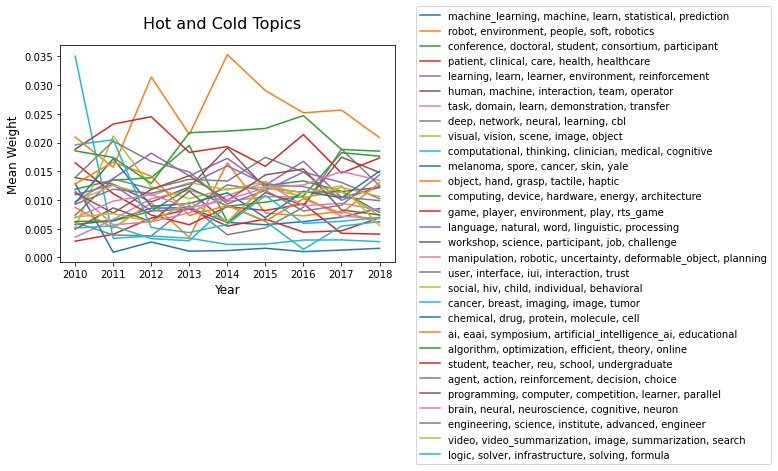

In [40]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [41]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [42]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [43]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [44]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [45]:
sort_slopes[:5]

[(13, 0.0013986556244569863),
 (8, 0.0012747640345570808),
 (16, 0.0011906339981769974),
 (27, 0.0008097830248855585),
 (23, 0.0004716996477860866)]

In [46]:
top_slopes

[13, 8, 16, 27, 23]

In [47]:
bottom_slopes

[11, 28, 14, 30, 10]

### plot hottest and coldest on same plot

In [48]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [49]:
topnbot_slopes

[13, 8, 16, 27, 23, 11, 28, 14, 30, 10]

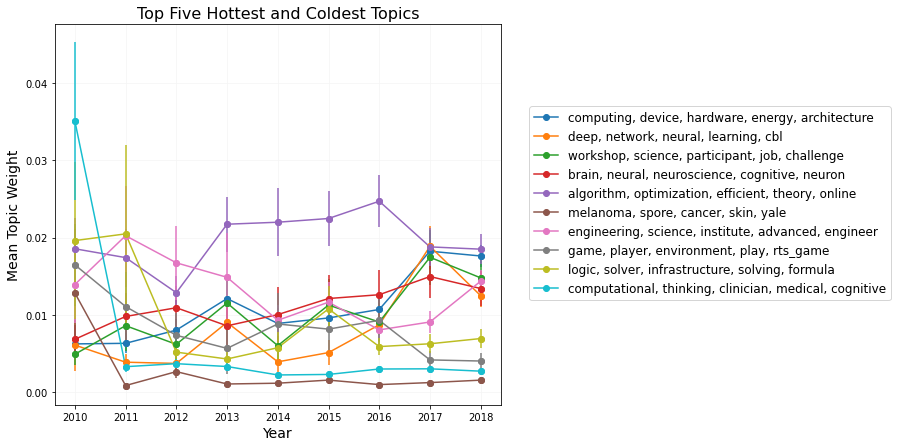

In [50]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


### Plot hottest and coldest topics on separate plots

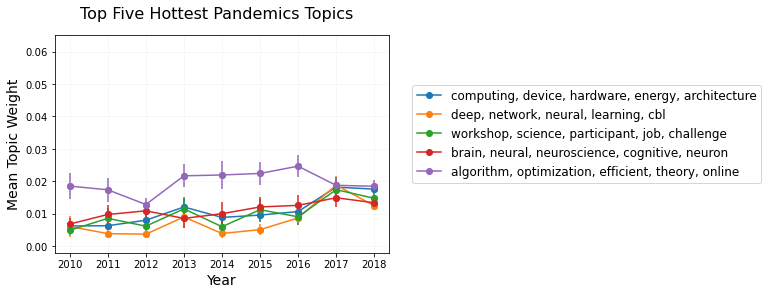

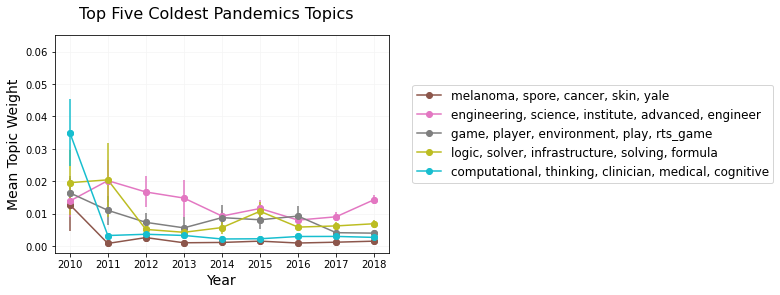

In [51]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_hot_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i+5]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_cold_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


### create plot for specific topics

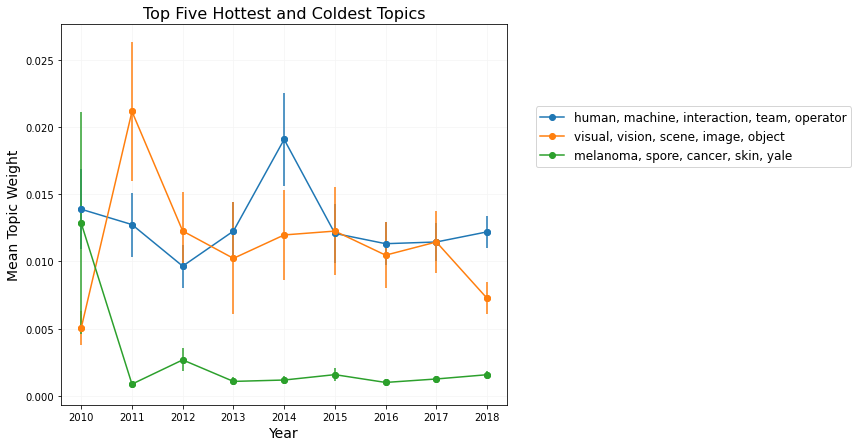

In [52]:
# Create plots for data stories in ET paper - topic numbers: 5, 8, 10 + 1 due to year being column 1

topic_idx = [6, 9, 11]

# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topic_idx:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in topic_idx], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in topic_idx], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/case-study.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [53]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[13,
 8,
 16,
 27,
 23,
 2,
 29,
 18,
 15,
 7,
 4,
 17,
 1,
 21,
 20,
 19,
 25,
 12,
 5,
 26,
 6,
 9,
 3,
 22,
 24,
 11,
 28,
 14,
 30,
 10]

In [54]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    
    

In [55]:
new_leg

['machine_learning, machine, learn, \n statistical, prediction',
 'robot, environment, people, \n soft, robotics',
 'conference, doctoral, student, \n consortium, participant',
 'patient, clinical, care, \n health, healthcare',
 'learning, learn, learner, \n environment, reinforcement',
 'human, machine, interaction, \n team, operator',
 'task, domain, learn, \n demonstration, transfer',
 'deep, network, neural, \n learning, cbl',
 'visual, vision, scene, \n image, object',
 'computational, thinking, clinician, \n medical, cognitive',
 'melanoma, spore, cancer, \n skin, yale',
 'object, hand, grasp, \n tactile, haptic',
 'computing, device, hardware, \n energy, architecture',
 'game, player, environment, \n play, rts_game',
 'language, natural, word, \n linguistic, processing',
 'workshop, science, participant, \n job, challenge',
 'manipulation, robotic, uncertainty, \n deformable_object, planning',
 'user, interface, iui, \n interaction, trust',
 'social, hiv, child, \n individual, b

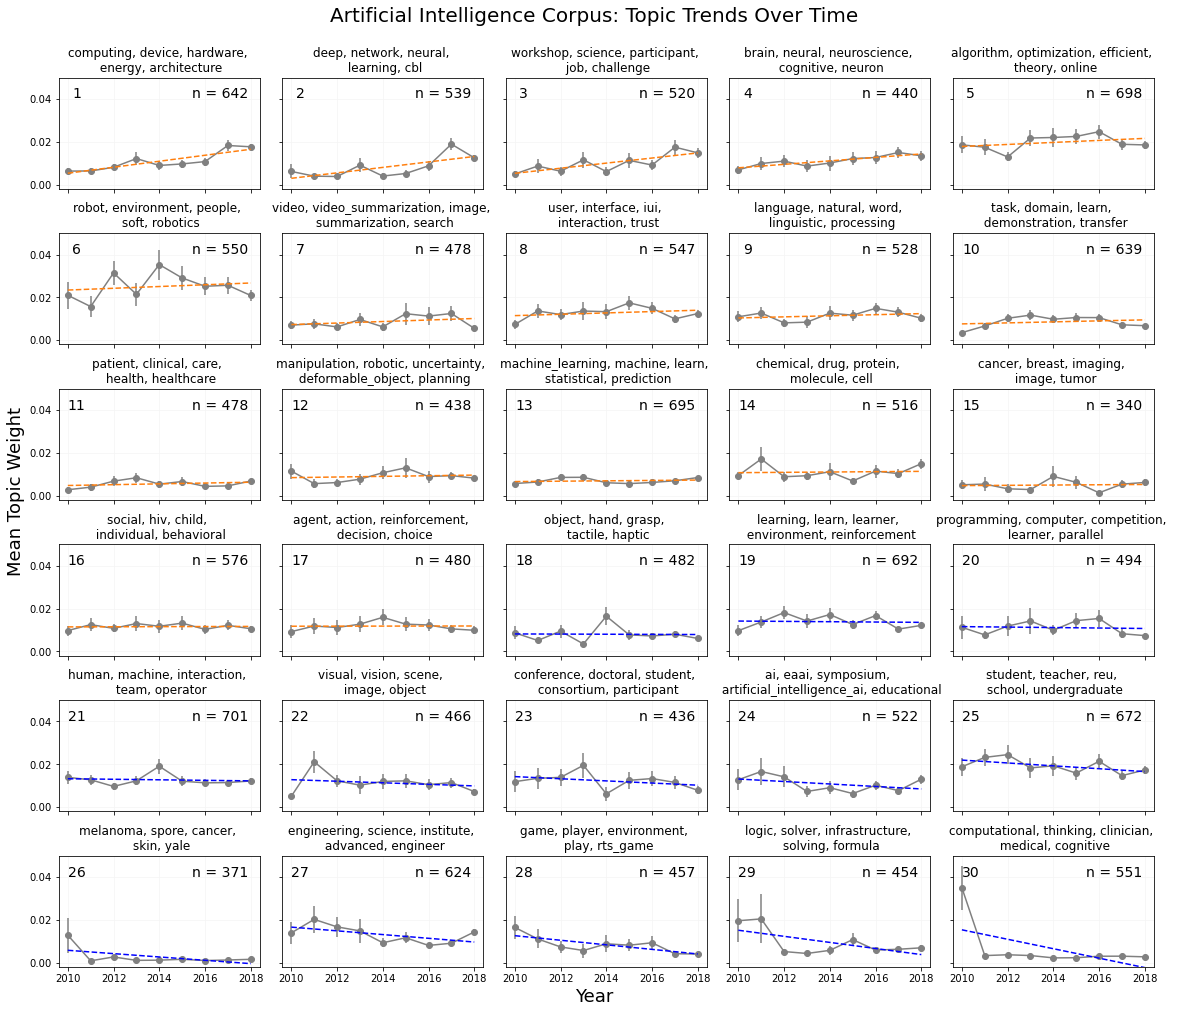

In [56]:
# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.05)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx-1], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.09, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx-1]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Artificial Intelligence Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig("figures/AI/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [57]:
# get legend items for too long titles (topic 2)

new_leg[sorted_slopes[16]-1]
new_leg[sorted_slopes[27]-1]


'game, player, environment, \n play, rts_game'

#### try other ways to show topic prevalence, number of projects, project costs

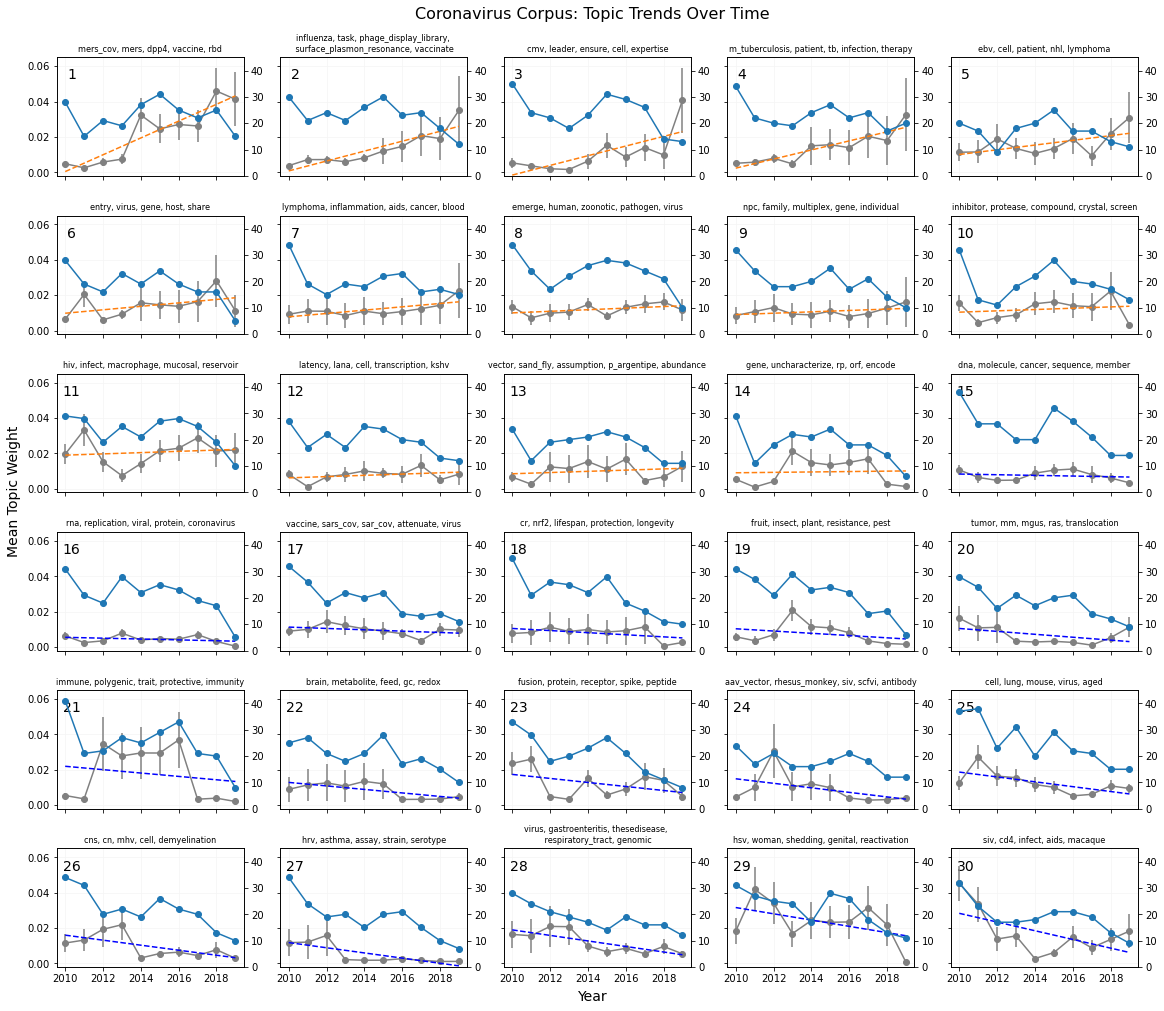

In [54]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

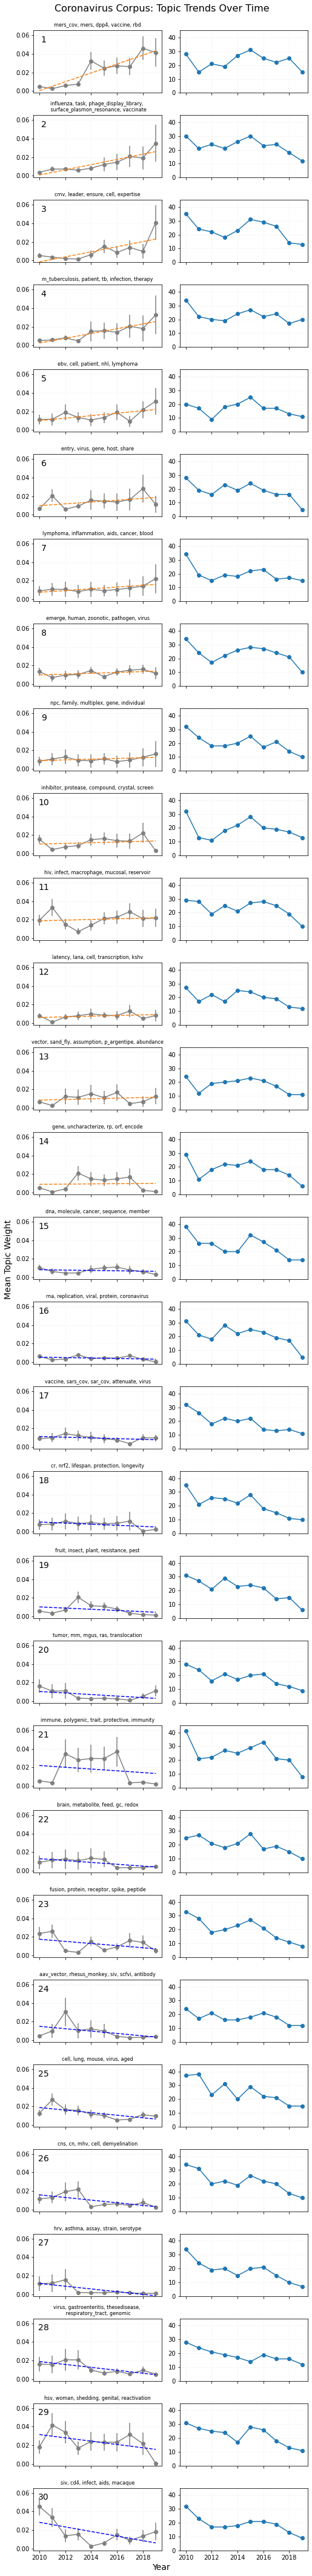

In [55]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,45)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [58]:
df["START_YEAR"].value_counts()

2018    345
2017    216
2016    160
2015    119
2012    109
2009     95
2014     95
2010     91
2013     84
2011     82
2019     77
2008     65
2006      8
2007      6
2004      3
1977      3
2005      3
2000      2
1987      2
2002      2
1997      1
2003      1
Name: START_YEAR, dtype: int64

In [59]:
df["DEPARTMENT"].value_counts()

NSF     1286
HHS      254
ED         9
DOD        6
VA         5
NASA       5
USDA       3
EPA        1
Name: DEPARTMENT, dtype: int64

In [60]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2019]  #2020

In [61]:
filt_df["START_YEAR"].value_counts().sort_index()
#filt_df["START_YEAR"].value_counts().sort_index().values

2010     91
2011     82
2012    109
2013     84
2014     95
2015    119
2016    160
2017    216
2018    345
Name: START_YEAR, dtype: int64

In [62]:
filt_df["DEPARTMENT"].value_counts()

NSF     1137
HHS      139
ED         9
NASA       5
DOD        4
USDA       3
VA         3
EPA        1
Name: DEPARTMENT, dtype: int64

In [63]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2011            1
            2017            1
            2018            2
ED          2012            3
            2014            1
            2015            1
            2016            3
            2018            1
EPA         2010            1
HHS         2010           17
            2011            9
            2012           12
            2013           13
            2014            6
            2015           11
            2016           17
            2017           17
            2018           37
NASA        2012            2
            2013            1
            2014            2
NSF         2010           71
            2011           71
            2012           91
            2013           70
            2014           86
            2015          106
            2016          140
            2017          198
            2018          304
USDA        2010            1
            2011            1
            2012 

In [64]:
filt_df.shape

(1301, 42)